In [1]:
# import packages
import sys
import os.path
import numpy as np
np.seterr(divide='ignore',invalid='ignore')
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns
sns.set()

from spykshrk.realtime.datatypes import Datatypes
import loren_frank_data_processing as lfdp
from loren_frank_data_processing import Animal
import trodes2SS
import scipy as sp
import sungod_util
from spykshrk.franklab.data_containers import RippleTimes, pos_col_format#FlatLinearPosition, SpikeFeatures, Posteriors, \
         #EncodeSettings, pos_col_format, SpikeObservation, RippleTimes, DayEpochEvent, DayEpochTimeSeries

%load_ext autoreload
%autoreload 2

idx = pd.IndexSlice
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 120)

In [ ]:
# cell to start up holoviews
import holoviews as hv

import scipy as sp

hv.extension('bokeh')

In [ ]:
# cell to test and make sure holoviews and bokeh are working
coords = np.random.rand(50,2)
points = hv.Points(coords)

points.opts(color='k', marker='+', size=10)

In [144]:
# cell to read real-time hdf5 file

#12-17, bill run session 3
#hdf_file = '/stelmo/mcoulter/spykshrk_output/bill/20191217_bill_05_r3_westerlies_streaming.rec_merged.h5'

#12-22, bill run session 
#hdf_file = '/stelmo/mcoulter/bill/raw/20191222/spykshrk_realtime_rec_files/20191222_bill_02_r1_westerlies_streaming.rec_merged.h5'

#1-17, remy day 20, epoch 2, 15 tets, ~1 hour
#hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_posterior_sum_1_16_1.rec_merged.h5'

#1-20, remy, day 20 , epoch 2, 15 tets, 100 uV
hdf_file = '/stelmo/mcoulter/spykshrk_output/greenflash/remy_decoder_15tet_1_20_100uV_decode.rec_merged.h5'


store = pd.HDFStore(hdf_file, mode='r')

In [140]:
# cell to fill in dataframes with realtime data
encoder_data = store['rec_3']
decoder_data = store['rec_4']
decoder_missed_spikes = store['rec_5']
likelihood_data = store['rec_6']
ripple_data = store['rec_1']
stim_state = store['rec_10']
stim_lockout = store['rec_11']
stim_message = store['rec_12']
timing = store['rec_100']

In [145]:
# cell to fill in dataframes with realtime data
encoder_data1 = store['rec_3']
decoder_data1 = store['rec_4']
decoder_missed_spikes1 = store['rec_5']
likelihood_data1 = store['rec_6']
ripple_data1 = store['rec_1']
stim_state1 = store['rec_10']
stim_lockout1 = store['rec_11']
stim_message1 = store['rec_12']
timing1 = store['rec_100']

In [147]:
encoder_data

,rec_ind,timestamp,elec_grp_id,position,x000,x001,x002,x003,x004,x005,...,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136
0,1,39691966,22,3.0,0.007342,0.007342,0.007342,0.001468,0.007342,0.007342,...,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342
1,2,39692126,26,3.0,0.007342,0.007342,0.007342,0.001468,0.007342,0.007342,...,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342
2,5,39692217,22,3.0,0.000071,0.000071,0.000071,0.990401,0.000071,0.000071,...,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071,0.000071
3,6,39692302,26,3.0,0.007342,0.007342,0.007342,0.001468,0.007342,0.007342,...,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342,0.007342
4,9,39692372,22,3.0,0.004123,0.004123,0.004123,0.439317,0.004123,0.004123,...,0.004123,0.004123,0.004123,0.004123,0.004123,0.004123,0.004123,0.004123,0.004123,0.004123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492006,190871,144166217,11,6.0,0.009716,0.010301,0.011443,0.007261,0.008481,0.007446,...,0.007043,0.006200,0.001840,0.005541,0.004765,0.008056,0.005001,0.007927,0.005865,0.005412
492007,190881,144169141,11,7.0,0.009670,0.011729,0.011506,0.008236,0.008990,0.007711,...,0.006425,0.003948,0.003575,0.007172,0.005226,0.006462,0.006125,0.006950,0.006122,0.007986
492008,190886,144169605,11,7.0,0.009229,0.009719,0.011392,0.007038,0.008496,0.007645,...,0.007361,0.007310,0.001890,0.005548,0.005364,0.008649,0.006118,0.008009,0.006485,0.005518
492009,190894,144171978,11,7.0,0.005391,0.012166,0.009534,0.007823,0.001172,0.006877,...,0.000092,0.002059,0.000267,0.034850,0.000069,0.037752,0.001972,0.014196,0.004810,0.006805


In [3]:
encoder_data1 = store['rec_3']
decoder_data1 = store['rec_4']
decoder_missed_spikes1 = store['rec_5']
ripple_data1 = store['rec_1']
stim_state1 = store['rec_10']
stim_lockout1 = store['rec_11']
stim_message1 = store['rec_12']
timing1 = store['rec_100']

In [4]:
# this shows the number of encoding spikes on each tetrode
for i in np.arange(1,30):
    print(i, encoder_data[encoder_data['elec_grp_id']==i].shape)

1 (4317, 77)
2 (0, 77)
3 (0, 77)
4 (109707, 77)
5 (6171, 77)
6 (75138, 77)
7 (0, 77)
8 (0, 77)
9 (12815, 77)
10 (4444, 77)
11 (0, 77)
12 (0, 77)
13 (0, 77)
14 (0, 77)
15 (0, 77)
16 (6015, 77)
17 (14281, 77)
18 (6089, 77)
19 (0, 77)
20 (2341, 77)
21 (5493, 77)
22 (0, 77)
23 (0, 77)
24 (1798, 77)
25 (3922, 77)
26 (0, 77)
27 (4961, 77)
28 (6403, 77)
29 (6139, 77)


In [ ]:
# need to go back to timing notebook to see how i plotted the timing delay in the lfp nodes
timing1[timing1['label'] == 'rip_recv']

In [8]:
stim_message1['next_ripple']=stim_message1['ripple_number'].diff()
stim_message1

,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,posterior_max_arm,content_threshold,...,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8,next_ripple
0,1,126605850,126606194,126606240,1.577059e+09,0,0,0,99,0.5,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN
1,3447,138073050,138073344,138073420,1.577060e+09,0,1,1,99,0.5,...,0.983922,0.001137,0.001196,0.010222,0.003523,0.0,0.0,0.0,0.0,1.0
2,3450,138073200,138073369,138073460,1.577060e+09,0,1,2,99,0.5,...,0.970431,0.002292,0.002741,0.019359,0.005177,0.0,0.0,0.0,0.0,0.0
3,3452,138073350,138073564,138073620,1.577060e+09,0,1,3,99,0.5,...,0.938835,0.007492,0.006188,0.034558,0.012928,0.0,0.0,0.0,0.0,0.0
4,3457,138073500,138073744,138073800,1.577060e+09,0,1,4,99,0.5,...,0.922288,0.009007,0.008917,0.045757,0.014031,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10759,82487,199224300,199224701,199224840,1.577062e+09,0,843,18,99,0.5,...,0.251165,0.089963,0.157748,0.394908,0.106217,0.0,0.0,0.0,0.0,0.0
10760,82488,199224600,199225241,199225400,1.577062e+09,0,843,19,99,0.5,...,0.200803,0.080158,0.173703,0.436478,0.108858,0.0,0.0,0.0,0.0,0.0
10761,82489,199224750,199225241,199225400,1.577062e+09,0,843,20,99,0.5,...,0.199062,0.082563,0.173606,0.434895,0.109875,0.0,0.0,0.0,0.0,0.0
10762,82490,199224900,199225241,199225400,1.577062e+09,0,843,21,99,0.5,...,0.198086,0.084959,0.173283,0.432499,0.111173,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


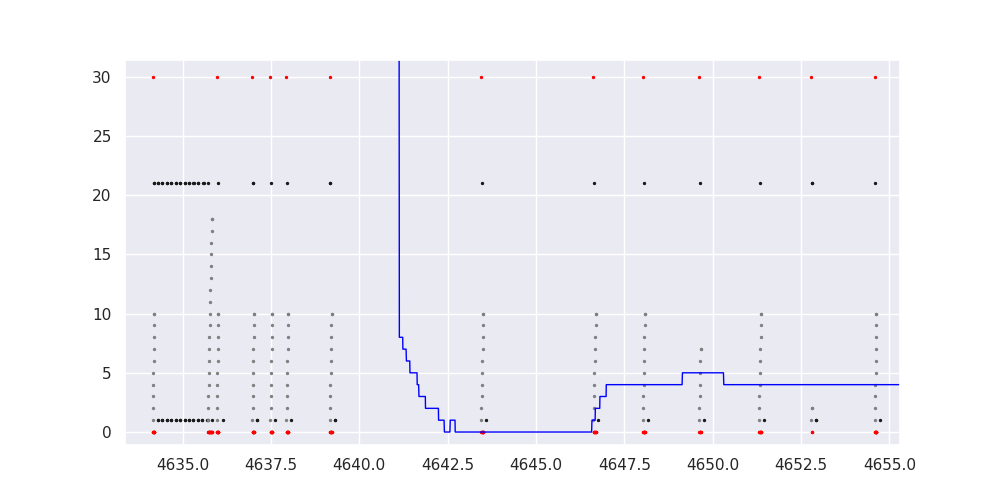

In [14]:
%matplotlib notebook

# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
#plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['stim_sent'].values)*10)+40,c='red',s=2)

# merged decoder stim message
#plt.scatter(merged_decoder_stim['bin_timestamp'].values/30000,((merged_decoder_stim['stim_sent'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout1['timestamp'].values/30000,((stim_lockout1['lockout_state'].values)*20)+1,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)

# plot next ripple transitions and ripple time bin
plt.scatter(stim_message1['bin_timestamp'].values/30000,((stim_message1['next_ripple'].values)*30)+0,c='red',s=2)
plt.scatter(stim_message1['bin_timestamp'].values/30000,((stim_message1['ripple_time_bin'].values)*1)+0,c='grey',s=2)


In [7]:
stim_message1['ripple_number'].diff()

0        NaN
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
10759    0.0
10760    0.0
10761    0.0
10762    0.0
10763    0.0
Name: ripple_number, Length: 10764, dtype: float64

In [ ]:
#adjust timestamp in realtime decoder_data to match offline timestamps
decoder_data_adj_ts = decoder_data.copy()
decoder_data_adj_ts['adj_timestamp'] = decoder_data_adj_ts['timestamp']+1960000
#df1 = df1.assign(adj_timestamp=e.values)
decoder_data_adj_ts.shape

In [45]:
#this is the most recent offline decode
file_path = '/stelmo/mcoulter/oct_2019_decoding/remy_20_2_shuffle_0_posteriors_functionalized_150_decode_whole.h5'
hdf_base = '/analysis'
hdf_grps = 'decode/clusterless/offline/posterior'
hdf_label = 'sungod_trans_mat'

with pd.HDFStore(file_path, 'r') as store:
    main_path = os.path.join(hdf_base, hdf_grps, hdf_label)
    posteriors2 = store[main_path]

In [46]:
# get linear position for offline

#### Define parameters
rat_name = 'remy'
day =  20     #previously:{'remy':[20], 'gus':[28], 'bernard':[23], 'fievel':[19]}
epoch = 2   # previously:{'remy':[4], 'gus':[2], 'bernard':[4], 'fievel':[2]} 

# define data source filepaths
path_base = '/stelmo/mcoulter/'
#path_base = '/mnt/vortex/mcoulter/'
raw_directory = path_base + 'raw_data/' + rat_name + '/'
linearization_path = path_base + 'maze_info/'
day_ep = str(day) + '_' + str(epoch)

#tetlist = None
tetlist = [4]
tetrodes= tetlist

pos_bin_size = 5
velocity_thresh_for_enc_dec = 4
velocity_buffer = 0

shift_amt_for_shuffle = 0

use_enc_as_dec = 1   #if you want to use the encoding marks as the decoding marks

discrete_tm_val=.99   # for classifier

# IMPORT and process data

#initialize data importer
datasrc = trodes2SS.TrodesImport(raw_directory, rat_name, [day], 
                       [epoch], tetrodes)

# Import trials
trials = datasrc.import_trials()

# Import raw position
linear_pos_raw = datasrc.import_pos(xy='x')   # this is basically just to pull in speed, will be replaced with linearized below
#posY = datasrc.import_pos(xy='y')          #  OPTIONAL; useful for 2d visualization

# if linearization exists, load it. if not, run the linearization.
lin_output1 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_distance.npy'
lin_output2 = linearization_path + rat_name + '/' + rat_name + '_' + day_ep + '_' + 'linearized_track_segments.npy'

if os.path.exists(lin_output1) == False:
    print('Linearization result doesnt exist. Doing linearization calculation')
    sungod_util.run_linearization_routine(rat_name, day, epoch, linearization_path, raw_directory, gap_size=20)
    linear_pos_raw['linpos_flat'] = np.load(lin_output1)
    track_segment_ids = np.load(lin_output2)
else: 
    print('Linearization found. Loading it')
    linear_pos_raw['linpos_flat'] = np.load(lin_output1)   #replace x pos with linerized 
    track_segment_ids = np.load(lin_output2)

# generate boundary definitions of each segment
arm_coords, _ = sungod_util.define_segment_coordinates(linear_pos_raw, track_segment_ids)  # optional addition output of all occupied positions (not just bounds)

#bin linear position 
binned_linear_pos, binned_arm_coords, pos_bins = sungod_util.bin_position_data(linear_pos_raw, arm_coords, pos_bin_size)

# Import ripples
rips_tmp = datasrc.import_rips(linear_pos_raw, velthresh=4) 
rips = RippleTimes.create_default(rips_tmp,1)  # cast to rippletimes obj
print('Rips less than velocity thresh: '+str(len(rips)))

Linearization found. Loading it
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  64.
  69.  74.  79.  84.  89.  94.  99. 104. 109. 114. 119. 124. 129. 134.
 139. 144. 147. 152. 157. 162. 167. 172. 177. 182. 187. 192. 197. 202.
 207. 212. 217. 222. 227. 232. 237. 242. 247. 252. 257. 262. 267. 272.
 277. 282. 287. 292. 297. 302. 307. 312. 317. 319. 324. 329. 334. 339.
 344. 349. 354. 359. 364. 369. 374. 379. 384. 389. 394. 399. 403. 408.
 413. 418. 423. 428. 433. 438. 443. 448. 453. 458. 463. 468. 473. 478.
 483. 485. 490. 495. 500. 505. 510. 515. 520. 525. 530. 535. 540. 545.
 550. 555. 560. 565. 568. 573. 578. 583. 588. 593. 598. 603. 608. 613.
 618. 623. 628. 633. 638. 643. 648. 649. 654. 659. 664. 669. 674. 679.
 684. 689. 694. 699. 704. 709. 714.]
[[  0   8]
 [ 13  25]
 [ 30  42]
 [ 47  59]
 [ 65  77]
 [ 82  94]
 [ 99 111]
 [116 128]
 [133 145]]
Rips less than velocity thresh: 1256


In [ ]:
# add linear position to offline posterior table
post_to_merge1 = posteriors2.copy()
post_to_merge1.reset_index(inplace=True)
post_to_merge1['timestamp1']=post_to_merge1['timestamp']
pos_vel = binned_linear_pos.copy()
pos_vel1 = pos_vel.reset_index()
pos_vel1['timestamp1'] = pos_vel1['timestamp']
pos_vel2 = pos_vel1.drop(['day','epoch','time','timestamp'], axis=1)
#pos_vel2
posterior_with_pos_vel = pd.merge_asof(post_to_merge1,pos_vel2,on='timestamp1',direction='nearest')


In [ ]:
#create posterior_to_plot
#posterior_offline = posteriors1.reset_index()
posterior_offline = posteriors2.reset_index()

# end of session - compared to real-time looking for arm 2 bias 154653600-157081200
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 154653600+1960000) & (posterior_offline['timestamp'] < 157081200+1960000)]

#this is a nice run down arm 7
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 47598850) & (posterior_offline['timestamp'] < 48921150)]

#this is a nice run down arm 5
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 103960800) & (posterior_offline['timestamp'] < 104769750)]
#offline_pos_to_plot = posterior_with_pos_vel[(posterior_with_pos_vel['timestamp1'] > 103960800) & (posterior_with_pos_vel['timestamp1'] < 104769750)]

#posterior_to_plot = posterior_offline[(posterior_offline['time'] > 3742.45) & (posterior_offline['time'] < 3742.55)]
# whole trial 60
#posterior_to_plot = posterior_offline[(posterior_offline['time'] > 3715) & (posterior_offline['time'] < 3755)]

#trial 60 replay 1
posterior_to_plot = posterior_offline[(posterior_offline['time'] > 3729) & (posterior_offline['time'] < 3730.4)]

print(posterior_to_plot.shape)

In [ ]:
#create decoder_to_plot
decoder_data_adj_ts = decoder_data.copy()
decoder_data_adj_ts['adj_timestamp'] = decoder_data_adj_ts['timestamp']+1960000

stim_lockout_adj_ts = stim_lockout.copy()
stim_lockout_adj_ts['adj_timestamp'] = stim_lockout_adj_ts['timestamp']+1960000

# shadow trials of arm 6 116141100 - 120145200
#decoder_to_plot = decoder_data_adj_ts[(decoder_data_adj_ts['timestamp'] > 116141100) & (decoder_data_adj_ts['timestamp'] < 120145200)]

# end of session strong bias to arm 2 154653600-157081200
#decoder_to_plot = decoder_data_adj_ts[(decoder_data_adj_ts['timestamp'] > 154653600) & (decoder_data_adj_ts['timestamp'] < 157081200)]

# a nice run down arm 7 - hmmm this doesnt look clear on the realtime decoder
#posterior_to_plot = posterior_offline[(posterior_offline['timestamp'] > 47598850) & (posterior_offline['timestamp'] < 48921150)]
#decoder_to_plot = decoder_data_adj_ts[(decoder_data_adj_ts['adj_timestamp'] > 47598850) & (decoder_data_adj_ts['adj_timestamp'] < 48921150)]

print(decoder_to_plot.shape)
print(stim_to_plot.shape)

In [ ]:
# get ripple times from offline posteriors dataframe
ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()
ripple_timestamps = posterior_to_plot[posterior_to_plot['ripple_grp'] > 0]['timestamp'].values - 1957500
#closest value lookup, return row
decoder_ripple_times = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[0]).abs().argsort()[:1]]
for i in np.arange(1,ripple_timestamps.shape[0]):
    ripple_row = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[i]).abs().argsort()[:1]]
    decoder_ripple_times = decoder_ripple_times.append(ripple_row)
    #print(i)
decoder_ripple_times.shape
#decoder_ripple_times.index.tolist()

In [ ]:
# offline posteriors, 150 uV threshold
# trial 60 - middle ripples - larger range is whole trial
#offline arm ends 8, 25, 42, 59, 77, 94, 111, 128, 145 
import seaborn as sns
sns.set()

#posterior_offline = posteriors1.reset_index()

#ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()

#ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] == 1386].tolist()
#ripple_start = ripple_times[0] - posterior_to_plot.index[0]
#print(ripple_start)
#ripple_end = ripple_times[-1] - posterior_to_plot.index[0]
#print(ripple_end)

posterior_offline1 = posterior_to_plot.drop(['day','epoch','timestamp','time','num_spikes','dec_bin','ripple_grp'], axis=1)
#posterior_offline1 = posterior_offline.drop(['day','epoch','timestamp','time','num_spikes','dec_bin','ripple_grp'], axis=1)
posterior_offline2 = posterior_offline1.fillna(0)
post_heatmap = posterior_offline2.transpose()

# to only plot a few position bins
#post_heatmap = posterior_offline2.transpose()[0:20]

#post_heatmap = posterior_offline2[425005:426825].transpose()
#replay 1
#post_heatmap = posterior_only[486533:486733].transpose()
#replay 2
#post_heatmap = posterior_only[487356:487776].transpose()

post_heatmap = post_heatmap.iloc[::-1]

plt.figure(figsize=(15,5))
ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
ax.hlines([145-10,145-27,145-44,145-61,145-79,145-96,145-113,145-130], lw=2, color='w',*ax.get_xlim())
#ax.scatter(np.arange(0,offline_pos_to_plot.shape[0]),145-offline_pos_to_plot['linpos_flat'].values,s=1,alpha=0.05,color='cyan')
#ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.2,*ax.get_ylim())

#ax.vlines([ripple_start],lw=2,color='w',alpha=0.3,*ax.get_ylim())
#ax.vlines([ripple_end],lw=2,color='w',alpha=0.3,*ax.get_ylim())
#sns.heatmap(post_hist1[50000:55000],vmin=0, vmax=0.5)

In [5]:
sent_messages = stim_message[stim_message['stim_sent']==1]
sent_messages.set_index('bin_timestamp',inplace=True)
sent_messages
sent_messages_list = sent_messages.index.tolist()
sent_messages_array = np.array(sent_messages_list)
sent_messages_array-205127550
stim_message

,rec_ind,bin_timestamp,spike_timestamp,time,stim_sent,ripple_number,ripple_time_bin,posterior_max_arm,content_threshold,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
0,67,174627300,174627480,1.576634e+09,0,1,1,10,0.8,1,1.000000,1.696804e-12,1.696804e-12,1.696804e-12,1.696804e-12,0.0,0.0,0.0,0.0
1,68,174627450,174627687,1.576634e+09,0,1,2,10,0.8,1,1.000000,2.949205e-08,2.949205e-08,2.949205e-08,2.949205e-08,0.0,0.0,0.0,0.0
2,69,174627600,174627796,1.576634e+09,0,1,3,10,0.8,1,1.000000,6.108996e-13,6.108996e-13,6.108996e-13,6.108996e-13,0.0,0.0,0.0,0.0
3,70,174627750,174628019,1.576634e+09,0,1,4,10,0.8,1,1.000000,2.199745e-08,2.199745e-08,2.199745e-08,2.199745e-08,0.0,0.0,0.0,0.0
4,71,174627900,174628067,1.576634e+09,0,1,5,10,0.8,1,1.000000,2.178247e-08,2.178247e-08,2.178247e-08,2.178247e-08,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49415,212243,282168000,282168796,1.576637e+09,0,632,68,10,0.6,1,0.034884,2.790565e-02,7.811054e-01,2.177018e-02,1.343345e-01,0.0,0.0,0.0,0.0
49416,212244,282168150,282168796,1.576637e+09,0,632,69,10,0.6,1,0.036483,2.968791e-02,7.757833e-01,2.360332e-02,1.344428e-01,0.0,0.0,0.0,0.0
49417,212245,282168300,282168796,1.576637e+09,0,632,70,10,0.6,1,0.038063,3.145882e-02,7.704735e-01,2.542456e-02,1.345801e-01,0.0,0.0,0.0,0.0
49418,212246,282168450,282168796,1.576637e+09,0,632,71,10,0.6,1,0.039627,3.321807e-02,7.651753e-01,2.723383e-02,1.347454e-01,0.0,0.0,0.0,0.0


In [18]:
# use pandas merge_asof to merge stim message into decoder data, then you can plot the ripples and stim messages
# on the heatmap of the posterior
# merge on bin_timestamp, do this before index is reset
# forward direction for merge extends 0 periods and keeps 1 as a short time (stim msssage sent)

stim_message1 = stim_message.copy()
stim_message2 = stim_message1.drop(['rec_ind','spike_timestamp','time',
                                   'ripple_number','ripple_time_bin',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='forward')
merged_decoder_stim


,rec_ind,bin_timestamp,wall_time,velocity,real_pos,spike_count,ripple,ripple_number,ripple_length,shortcut_message,...,x65,x66,x67,x68,x69,x70,x71,x72,stim_sent,posterior_max_arm
0,1,174433200,1.576634e+09,314.011683,0.0,3,0,0,0,0,...,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,1.777774e-02,0.0,10.0
1,2,174433500,1.576634e+09,314.011683,0.0,3,0,0,0,0,...,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,1.791655e-02,0.0,10.0
2,3,174433650,1.576634e+09,314.011683,0.0,0,0,0,0,0,...,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,1.791440e-02,0.0,10.0
3,5,174433950,1.576634e+09,314.011683,0.0,1,0,0,0,0,...,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,3.718177e-04,0.0,10.0
4,6,174434100,1.576634e+09,314.011683,0.0,1,0,0,0,0,...,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,1.729657e-08,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576860,643613,282481950,1.576637e+09,3.478607,1.0,1,0,0,0,0,...,4.744892e-02,5.744098e-02,6.667936e-02,5.923395e-02,4.663491e-02,2.680227e-02,1.582633e-02,6.205174e-03,NaN,NaN
576861,643614,282482100,1.576637e+09,3.478607,1.0,1,0,0,0,0,...,4.251042e-02,6.760395e-02,7.598804e-02,7.337274e-02,5.423333e-02,2.692719e-02,1.516381e-02,6.014564e-03,NaN,NaN
576862,643615,282482250,1.576637e+09,3.478607,1.0,1,0,0,0,0,...,4.231307e-02,7.152026e-02,8.901394e-02,8.887999e-02,6.138022e-02,2.911804e-02,1.503579e-02,6.070540e-03,NaN,NaN
576863,643616,282482400,1.576637e+09,3.478607,1.0,0,0,0,0,0,...,5.074662e-02,6.733201e-02,8.276635e-02,7.940546e-02,5.955334e-02,3.507809e-02,1.674601e-02,9.107033e-03,NaN,NaN


In [25]:
# use pandas merge_asof to merge stim lockout into decoder data, this will plot decode heatmap and start of ripple
# merge on bin_timestamp, do this before index is reset
# backward direction for merge marks ripples with lockout_state = 1
# this looks like it works as exepcted
# BUT: the timestamps are not quite the same, the stim_lockout timestamps are LFP timestamps not decoder timestamps

stim_lockout_1 = stim_lockout1.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout1['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(decode_to_merge,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,spike_count,ripple,ripple_number,ripple_length,shortcut_message,...,x64,x65,x66,x67,x68,x69,x70,x71,x72,lockout_state
0,1,126605700,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,NaN
1,2,126605850,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,NaN
2,3,126606150,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,NaN
3,4,126606450,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,NaN
4,5,126606600,1.577059e+09,233.131206,0.0,1,0,0,0,0,...,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394295,408357,199392900,1.577062e+09,3.367697,24.0,1,0,0,0,0,...,3.251357e-04,3.037774e-04,2.890457e-04,2.755001e-04,2.566465e-04,2.865070e-04,1.514040e-01,3.201128e-01,4.987452e-01,0.0
394296,408358,199393050,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,4.269254e-04,4.036860e-04,3.872346e-04,3.716133e-04,3.707718e-04,5.046152e-02,1.564762e-01,3.216878e-01,4.368102e-01,0.0
394297,408359,199393200,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,5.156281e-04,5.030820e-04,4.847491e-04,4.738398e-04,1.707070e-02,6.881074e-02,1.753096e-01,3.033628e-01,3.962762e-01,0.0
394298,408360,199393350,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,6.103108e-04,5.977468e-04,5.838963e-04,6.075143e-03,2.872143e-02,8.666980e-02,1.815598e-01,2.900965e-01,3.633330e-01,0.0


In [26]:
stim_message

,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,spike_count,ripple_time_bin,posterior_max_arm,...,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
0,1,39692100,39692302,39692360,1.579222e+09,0,0,0,0,99,...,1,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
1,6882,42054000,42054454,42054760,1.579222e+09,0,1,1,1,99,...,1,0.981569,0.002187,0.000527,9.746506e-08,0.001170,9.746506e-08,0.006770,9.746506e-08,0.007776
2,6884,42054150,42054454,42054800,1.579222e+09,0,1,2,2,99,...,1,0.972175,0.003467,0.001836,1.323400e-03,0.002424,1.323400e-03,0.007749,1.323400e-03,0.008377
3,6887,42054450,42054916,42055040,1.579222e+09,0,1,3,4,99,...,1,0.957612,0.002233,0.010464,8.620366e-11,0.001737,8.620366e-11,0.017655,8.620366e-11,0.010300
4,6889,42054600,42054916,42055040,1.579222e+09,0,1,4,6,99,...,1,0.946618,0.003833,0.012029,1.673932e-03,0.003298,1.673932e-03,0.018424,1.673932e-03,0.010776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7546,327319,143968200,143968683,143968820,1.579225e+09,0,452,3,8,99,...,1,0.133069,0.819165,0.028822,1.476452e-03,0.003163,4.458061e-03,0.004117,2.121415e-03,0.003608
7547,327321,143968350,143968683,143968840,1.579225e+09,0,452,4,9,99,...,1,0.134646,0.808104,0.028746,3.169823e-03,0.004699,5.978172e-03,0.005749,3.800517e-03,0.005108
7548,327323,143968650,143968810,143968860,1.579225e+09,0,452,5,11,99,...,1,0.166930,0.713846,0.079265,2.695233e-03,0.006432,9.211718e-03,0.008505,6.113532e-03,0.007001
7549,327325,143968800,143969031,143969140,1.579225e+09,0,452,6,13,99,...,1,0.093868,0.904922,0.000002,2.881266e-07,0.000348,3.494388e-05,0.000135,3.472772e-07,0.000690


In [41]:
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
# for stim_message this merge ('nearest') put the arm number and ripple number at all timebins after the end of the rippple
# for stim_lockout this merge ('backward') will highlight the ripple time
stim_message1 = stim_message.copy()
stim_message2 = stim_message1.drop(['rec_ind','spike_timestamp','lfp_timestamp','time',
                                   'ripple_time_bin','spike_count',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='nearest')
merged_decoder_stim

stim_lockout_1 = stim_lockout.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
##decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,raw_x,raw_y,smooth_x,smooth_y,spike_count,...,x132,x133,x134,x135,x136,shortcut_message_sent,ripple_number_y,posterior_max_arm,ripple_end,lockout_state
0,2,39691950,1.579222e+09,1177.802009,3.0,682.0,364.0,106.8110,57.2001,2,...,9.596921e-03,9.596921e-03,9.596921e-03,9.596921e-03,9.596921e-03,0,0,99,1,NaN
1,4,39692100,1.579222e+09,1177.802009,3.0,682.0,364.0,106.8110,57.2001,2,...,4.607927e-04,4.607927e-04,4.607927e-04,4.607927e-04,4.607927e-04,0,0,99,1,NaN
2,6,39692250,1.579222e+09,1470.564953,3.0,680.0,362.0,133.1254,71.2072,2,...,7.509345e-05,7.509345e-05,7.509345e-05,7.509345e-05,7.509345e-05,0,0,99,1,NaN
3,8,39692400,1.579222e+09,1470.564953,3.0,680.0,362.0,133.1254,71.2072,1,...,2.347661e-04,2.347661e-04,2.347661e-04,2.347661e-04,2.347661e-04,0,0,99,1,NaN
4,10,39692550,1.579222e+09,1470.564953,3.0,680.0,362.0,133.1254,71.2072,1,...,4.464398e-04,4.464398e-04,4.464398e-04,4.464398e-04,4.464398e-04,0,0,99,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563016,1195008,144173100,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,1,...,5.569374e-07,8.030340e-07,1.425664e-08,1.393337e-07,7.360622e-09,0,452,99,0,1.0
563017,1195010,144173250,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,3,...,2.161892e-06,1.144642e-05,2.484156e-07,1.103664e-06,2.947634e-07,0,452,99,0,1.0
563018,1195012,144173550,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,1,...,8.438110e-05,7.591057e-05,8.039253e-05,8.024402e-05,1.068855e-04,0,452,99,0,1.0
563019,1195014,144173700,1.579225e+09,326.843364,7.0,599.0,517.0,642.0141,502.7160,2,...,1.769158e-07,8.673799e-06,2.551450e-06,1.203729e-05,1.000132e-05,0,452,99,0,1.0


<IPython.core.display.Javascript object>


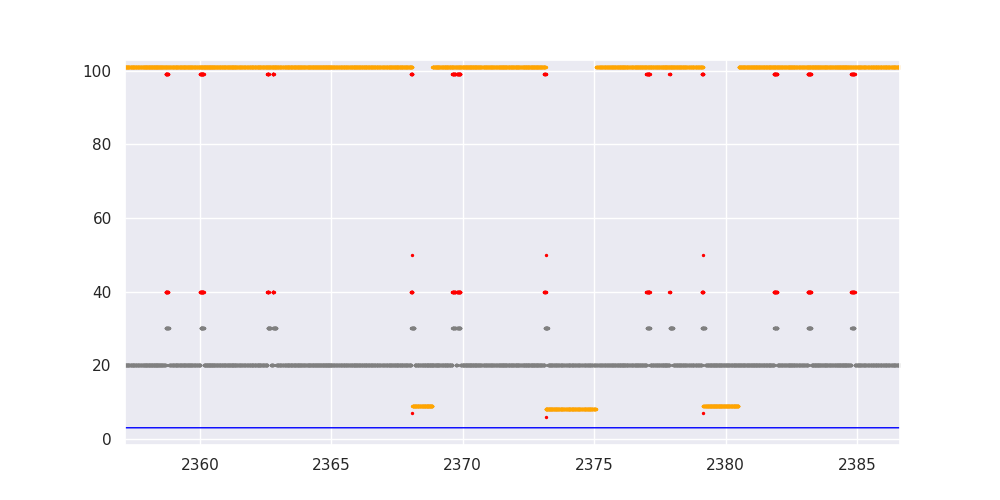

In [42]:
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data['bin_timestamp'].values)/30000,(((decoder_data['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['shortcut_message_sent'].values)*10)+40,c='red',s=2)
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['posterior_max_arm'].values)*1)+0,c='red',s=2)
##plot lockout time
#plt.scatter(stim_lockout['timestamp'].values/30000,((stim_lockout['lockout_state'].values)*10)+35,c='k',s=2)

# merged decoder stim message - ripple end
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['posterior_max_arm'].values)*1)+2,c='orange',s=2)
## merged decoder lockout - ripple start
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['lockout_state'].values)*10)+20,c='grey',s=2)


In [14]:
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
stim_message1 = stim_message.copy()
stim_message2 = stim_message1.drop(['rec_ind','spike_timestamp','time',
                                   'ripple_number','ripple_time_bin',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='forward')
merged_decoder_stim

stim_lockout_1 = stim_lockout.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
#decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout

,rec_ind,bin_timestamp,wall_time,velocity,real_pos,spike_count,ripple,ripple_number,ripple_length,shortcut_message,...,x68,x69,x70,x71,x72,lfp_timestamp,shortcut_message_sent,posterior_max_arm,ripple_end,lockout_state
0,1,126605700,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,1.775139e-02,126606240.0,0.0,99.0,1.0,NaN
1,2,126605850,1.577059e+09,233.993776,0.0,2,0,0,0,0,...,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,1.757273e-02,126606240.0,0.0,99.0,1.0,NaN
2,3,126606150,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,8.157706e-05,138073420.0,0.0,99.0,0.0,NaN
3,4,126606450,1.577059e+09,233.993776,0.0,1,0,0,0,0,...,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,8.491597e-08,138073420.0,0.0,99.0,0.0,NaN
4,5,126606600,1.577059e+09,233.131206,0.0,1,0,0,0,0,...,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,3.397357e-09,138073420.0,0.0,99.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394295,408357,199392900,1.577062e+09,3.367697,24.0,1,0,0,0,0,...,2.566465e-04,2.865070e-04,1.514040e-01,3.201128e-01,4.987452e-01,NaN,NaN,NaN,NaN,0.0
394296,408358,199393050,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,3.707718e-04,5.046152e-02,1.564762e-01,3.216878e-01,4.368102e-01,NaN,NaN,NaN,NaN,0.0
394297,408359,199393200,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,1.707070e-02,6.881074e-02,1.753096e-01,3.033628e-01,3.962762e-01,NaN,NaN,NaN,NaN,0.0
394298,408360,199393350,1.577062e+09,3.367697,24.0,0,0,0,0,0,...,2.872143e-02,8.666980e-02,1.815598e-01,2.900965e-01,3.633330e-01,NaN,NaN,NaN,NaN,0.0


<IPython.core.display.Javascript object>


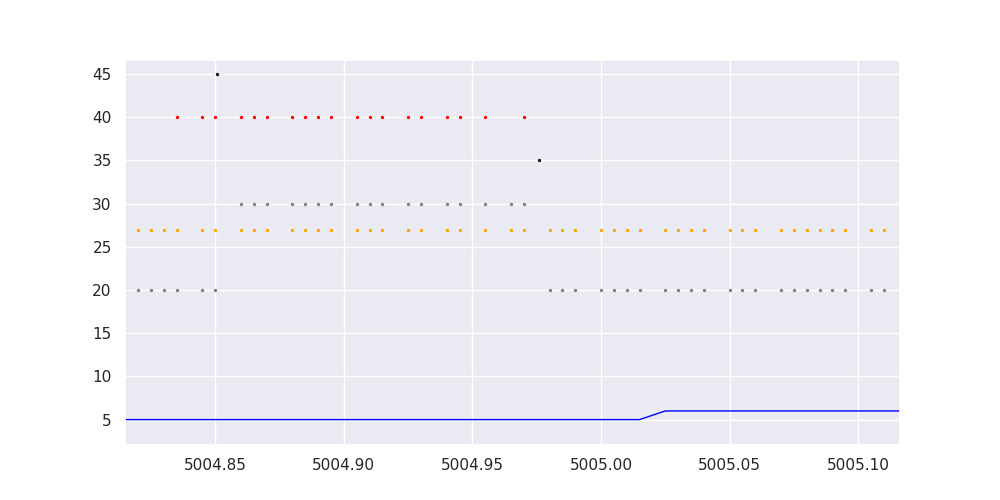

In [20]:
%matplotlib notebook
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data['bin_timestamp'].values)/30000,(((decoder_data['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['shortcut_message_sent'].values)*10)+40,c='red',s=2)
#plot lockout time
plt.scatter(stim_lockout['timestamp'].values/30000,((stim_lockout['lockout_state'].values)*10)+35,c='k',s=2)

# merged decoder stim message - ripple end
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['shortcut_message_sent'].values)*10)+27,c='orange',s=2)
# merged decoder lockout - ripple start
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['lockout_state'].values)*10)+20,c='grey',s=2)


#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


<IPython.core.display.Javascript object>


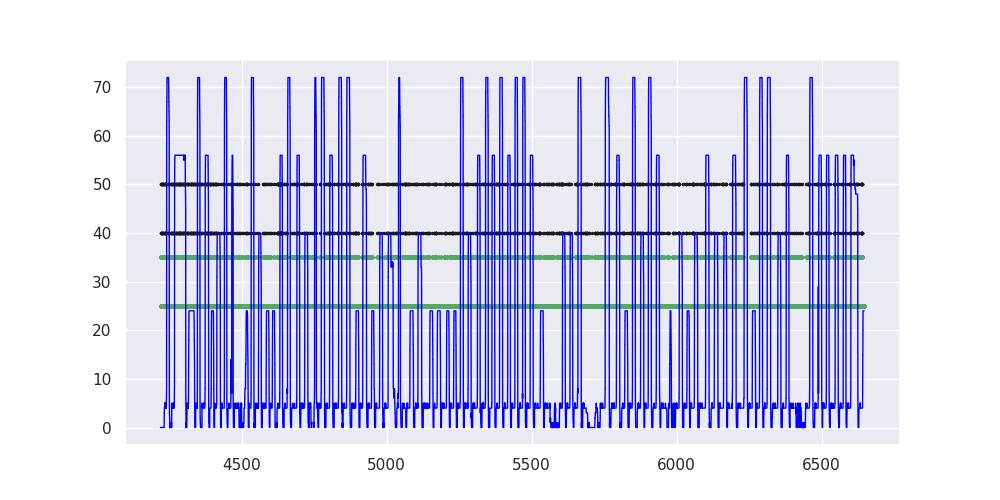

In [27]:
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
#plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['stim_sent'].values)*10)+40,c='red',s=2)

# merged decoder stim message
plt.scatter(merged_decoder_lockout['bin_timestamp'].values/30000,((merged_decoder_lockout['lockout_state'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout1['timestamp'].values/30000,((stim_lockout1['lockout_state'].values)*10)+40,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


In [ ]:
plt.scatter(merged_decoder_stim['bin_timestamp'][9700:10000].values/30000,merged_decoder_stim['stim_sent'][9700:10000].values)
#plt.scatter(stim_message['bin_timestamp'][1000:1300].values/30000,stim_message['stim_sent'][1000:1300].values)


In [23]:
# subset of decoder_data to plot
#decoder_to_plot = decoder_data[(decoder_data['bin_timestamp'] > 205127400) & (decoder_data['bin_timestamp'] < 205636350)]
#decoder_to_plot.set_index('bin_timestamp',inplace=True)
#posterior_only = decoder_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
#                                       'spike_count','ripple','ripple_number','ripple_length',
#                                      'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
#                                      'arm6','arm7','arm8'], axis=1)

#posterior from decode/stim message merged table
merged_to_plot = merged_decoder_stim[(merged_decoder_stim['bin_timestamp'] > 205127400) & (merged_decoder_stim['bin_timestamp'] < 205636350)]
merged_to_plot.set_index('bin_timestamp',inplace=True)
posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
                                            'spike_count','ripple','ripple_number','ripple_length',
                                            'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                            'arm6','arm7','arm8','posterior_max_arm','stim_sent'], axis=1)
#posterior_only
posterior_only_merged
#decoder_to_plot.set_index('bin_timestamp',inplace=True)
#decoder_to_plot


,x00,x01,x02,x03,x04,x05,x06,x07,x08,x09,...,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72
bin_timestamp,,,,,,,,,,,,,,,,,,,,,
205127550,0.001192,0.001013,0.001147,0.001433,0.001563,0.001578,0.002206,0.003016,0.006808,0.0,...,0.048220,0.037324,0.073135,0.122442,0.185068,0.173513,0.106544,0.061503,0.029291,0.006295
205127700,0.001226,0.001211,0.001290,0.001472,0.001615,0.001871,0.002353,0.003584,0.008010,0.0,...,0.038326,0.052693,0.077293,0.126262,0.159532,0.154262,0.113307,0.065506,0.032279,0.013980
205127850,0.001313,0.001335,0.001416,0.001550,0.001743,0.002035,0.002687,0.004135,0.007760,0.0,...,0.041501,0.055885,0.085031,0.120443,0.145954,0.141660,0.110495,0.070065,0.037143,0.020065
205128150,0.000598,0.001382,0.001642,0.002331,0.001935,0.002729,0.003096,0.007052,0.011990,0.0,...,0.036547,0.037890,0.048314,0.122609,0.111309,0.143649,0.121626,0.076901,0.050551,0.010485
205128300,0.000475,0.000918,0.001412,0.001316,0.001344,0.001872,0.003555,0.005951,0.009766,0.0,...,0.056571,0.030498,0.080533,0.116801,0.139201,0.165888,0.091847,0.068471,0.037319,0.013050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205635300,0.188509,0.236966,0.184011,0.175251,0.107192,0.046119,0.006831,0.007341,0.001100,0.0,...,0.000877,0.001363,0.003092,0.001010,0.002172,0.001496,0.004043,0.000640,0.000654,0.000955
205635450,0.203597,0.202111,0.197717,0.154704,0.108998,0.053178,0.020083,0.005989,0.001808,0.0,...,0.001113,0.001867,0.001911,0.002179,0.001650,0.002655,0.002147,0.001868,0.000845,0.000949
205635600,0.202047,0.200103,0.183897,0.153036,0.105127,0.060508,0.026366,0.009894,0.001713,0.0,...,0.001352,0.001720,0.002074,0.002002,0.002249,0.002238,0.002310,0.001710,0.001313,0.001009


In [ ]:
ripples_to_plot = merged_to_plot.reset_index()
ripples_to_plot
ripple_times = ripples_to_plot.index[ripples_to_plot['stim_sent'] > 0].tolist()
ripple_times

In [37]:
stim_lockout

,rec_ind,timestamp,time,lockout_num,lockout_state,tets_above_thresh,ripple_cond_message_sent
0,9,174468760,2.620759e+02,0,0,2,0
1,10,174468780,2.620759e+02,0,0,2,0
2,11,174468920,2.620759e+02,0,0,2,0
3,12,174468940,2.620759e+02,0,0,2,0
4,13,174468940,2.620759e+02,0,0,2,0
...,...,...,...,...,...,...,...
2638,210976,281640540,1.576637e+09,835,0,0,0
2639,211388,281939380,6.618800e+00,836,1,2,0
2640,211527,281954400,1.576637e+09,836,0,0,0
2641,212138,282155780,3.546008e+00,837,1,2,0


<IPython.core.display.Javascript object>


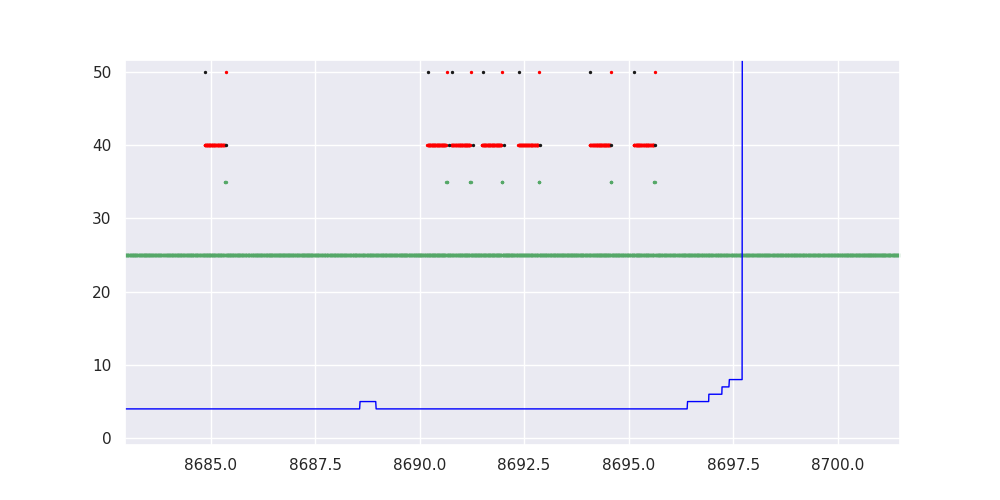

In [41]:
# plot to confirm that stim message is 500 msec after ripple (line up with lockout state)
# and to see how the merged changed the time stamps for stim message = 1
plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data['bin_timestamp'].values)/30000,(((decoder_data['real_pos'].values)*1)/1),c='blue',linewidth=1)

#realtime ripples: stim message
plt.scatter(stim_message['bin_timestamp'].values/30000,((stim_message['stim_sent'].values)*10)+40,c='red',s=2)

# merged decoder stim message
plt.scatter(merged_decoder_stim['bin_timestamp'].values/30000,((merged_decoder_stim['stim_sent'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout['timestamp'].values/30000,((stim_lockout['lockout_state'].values)*10)+40,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


In [52]:
stim_message1[stim_message1['ripple_end']==1]

,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,posterior_max_arm,content_threshold,...,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
0,1,126605850,126606194,126606240,1.577059e+09,0,0,0,99,0.5,...,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11,3471,138074550,138075595,138075700,1.577060e+09,1,1,10,0,0.5,...,1,0.906853,0.008242,0.007692,0.061933,0.015279,0.0,0.0,0.0,0.0
22,3724,138383400,138384158,138384300,1.577060e+09,1,2,10,4,0.5,...,1,0.014089,0.019722,0.025151,0.033837,0.907201,0.0,0.0,0.0,0.0
33,3749,138390450,138390715,138390800,1.577060e+09,1,3,10,4,0.5,...,1,0.027573,0.034600,0.028070,0.051067,0.858690,0.0,0.0,0.0,0.0
54,3990,138633900,138634854,138634940,1.577060e+09,0,4,20,99,0.5,...,1,0.195683,0.174938,0.157852,0.242158,0.229369,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,82279,199151250,199157060,199157160,1.577062e+09,0,838,9,99,0.5,...,1,0.514029,0.055288,0.273203,0.095474,0.062005,0.0,0.0,0.0,0.0
10688,82312,199179750,199180052,199180240,1.577062e+09,1,839,10,0,0.5,...,1,0.670729,0.003119,0.004404,0.004048,0.317700,0.0,0.0,0.0,0.0
10722,82410,199189350,199194377,199194440,1.577062e+09,0,841,33,3,0.5,...,1,0.180104,0.047266,0.116917,0.522499,0.133214,0.0,0.0,0.0,0.0
10741,82455,199218300,199218944,199219120,1.577062e+09,0,842,18,3,0.5,...,1,0.020768,0.015887,0.296846,0.508768,0.157730,0.0,0.0,0.0,0.0


In [59]:
stim_message1[10705:10715]

,rec_ind,bin_timestamp,spike_timestamp,lfp_timestamp,time,shortcut_message_sent,ripple_number,ripple_time_bin,posterior_max_arm,content_threshold,...,max_arm_repeats,box,arm1,arm2,arm3,arm4,arm5,arm6,arm7,arm8
10705,82349,199186500,199186694,199186880,1.577062e+09,0,840,17,99,0.5,...,1,0.051556,0.021081,0.216927,0.688206,0.022230,0.0,0.0,0.0,0.0
10706,82350,199186650,199186835,199187020,1.577062e+09,0,840,18,99,0.5,...,1,0.056618,0.021921,0.187224,0.708634,0.025603,0.0,0.0,0.0,0.0
10707,82351,199186800,199186996,199187060,1.577062e+09,0,840,19,99,0.5,...,1,0.054837,0.023364,0.192904,0.700891,0.028004,0.0,0.0,0.0,0.0
10708,82359,199186950,199187194,199187300,1.577062e+09,0,840,20,99,0.5,...,1,0.099402,0.028695,0.165799,0.649894,0.056210,0.0,0.0,0.0,0.0
10709,82370,199187100,199187273,199188180,1.577062e+09,0,841,21,99,0.5,...,1,0.071620,0.031247,0.179995,0.653514,0.063624,0.0,0.0,0.0,0.0
10710,82372,199187250,199187441,199188260,1.577062e+09,0,841,22,99,0.5,...,1,0.085884,0.027732,0.149108,0.669808,0.067468,0.0,0.0,0.0,0.0
10711,82373,199187400,199187598,199188280,1.577062e+09,0,841,23,99,0.5,...,1,0.056406,0.021168,0.148298,0.700635,0.073493,0.0,0.0,0.0,0.0
10712,82374,199187550,199187713,199188400,1.577062e+09,0,841,24,99,0.5,...,1,0.061908,0.021905,0.133331,0.711492,0.071364,0.0,0.0,0.0,0.0
10713,82378,199187700,199187959,199188480,1.577062e+09,0,841,25,99,0.5,...,1,0.051074,0.024564,0.140960,0.713077,0.070325,0.0,0.0,0.0,0.0
10714,82383,199187850,199188055,199188520,1.577062e+09,0,841,26,99,0.5,...,1,0.035442,0.012394,0.130820,0.751616,0.069728,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


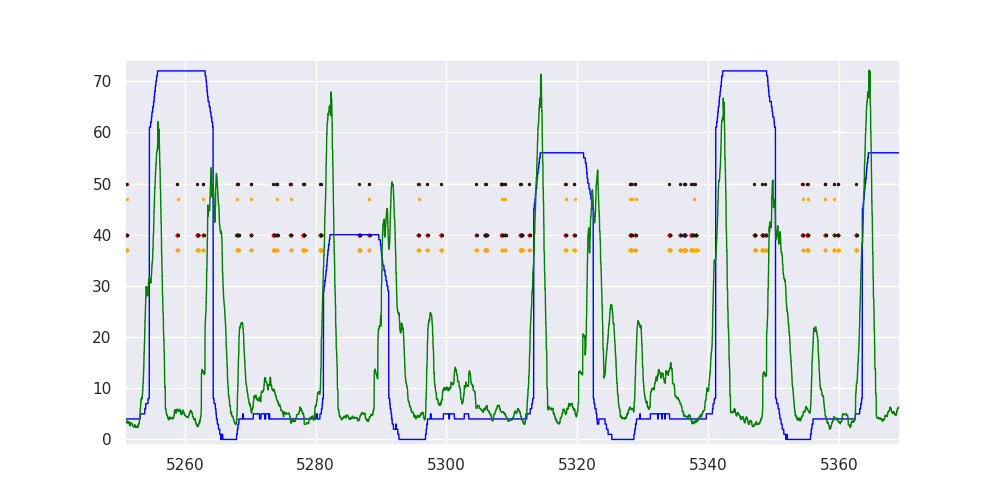

In [51]:
# look at time delay for stim message with new posterior sum function

plt.figure(figsize=(10,5))
#realtime position with adjusted timestamp
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['real_pos'].values)*1)/1),c='blue',linewidth=1)
plt.plot((decoder_data1['bin_timestamp'].values)/30000,(((decoder_data1['velocity'].values)*1)/1),c='green',linewidth=1)


#realtime ripples: stim message
plt.scatter(stim_message1['bin_timestamp'].values/30000,((stim_message1['shortcut_message_sent'].values)*10)+40,c='red',s=2)
plt.scatter(stim_message1['lfp_timestamp'].values/30000,((stim_message1['shortcut_message_sent'].values)*10)+37,c='orange',s=2)

# merged decoder stim message
#plt.scatter(merged_decoder_stim['bin_timestamp'].values/30000,((merged_decoder_stim['stim_sent'].values)*10)+25,c='g',s=2)

#ripple threshold
#plt.plot((ripple_data9['timestamp'].values)/30000,(((ripple_data9['ripple_threshold'].values)*3)/1),c='red',linewidth=1)

#plot lockout time
plt.scatter(stim_lockout1['timestamp'].values/30000,((stim_lockout1['lockout_state'].values)*10)+40,c='k',s=2)

#plot velocity - zero at 15, cut-off for ripple detection
#plt.plot((decoder_data9['bin_timestamp'].values)/30000,(((decoder_data9['velocity'].values))/1),c='grey',linewidth=1)


<IPython.core.display.Javascript object>


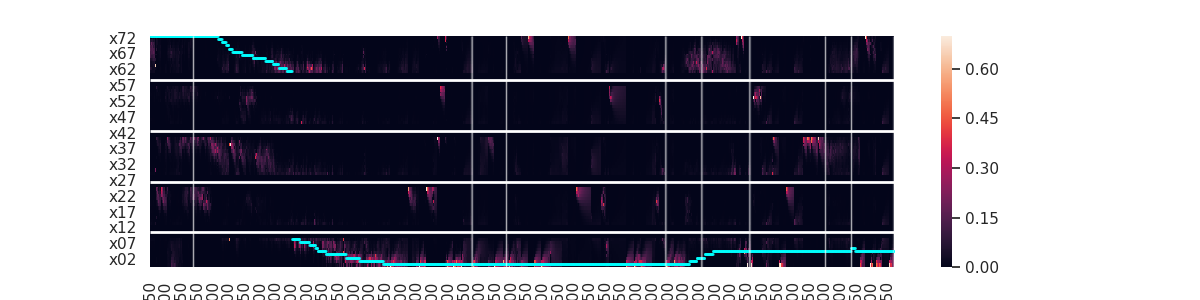

In [33]:
%matplotlib notebook
# all tetrodes (21) for full session on drought, 150 uV threshold, good linearization, adjusted TS
# 20 tetrodes for full session on drought, 150 uV threshold, adjusted timestamps
# realtime arm ends: 1, 17, 33, 49, 65, 81, 97, 113, 129
# new arm ends: 7, 23, 39, 55, 71, 87, 103, 119, 135
import seaborn as sns
sns.set()

#ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()
#this value is currently just emprically set
#ripple_timestamps = posterior_to_plot[posterior_to_plot['ripple_grp'] > 0]['timestamp'].values - 1958800
#closest value lookup, return row
#decoder_ripple_times = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[0]).abs().argsort()[:1]]
#for i in np.arange(1,ripple_timestamps.shape[0]):
#    ripple_row = decoder_to_plot.iloc[(decoder_to_plot['timestamp']-ripple_timestamps[i]).abs().argsort()[:1]]
#    decoder_ripple_times = decoder_ripple_times.append(ripple_row)
    #print(i)
#decoder_ripple_times
#decoder_ripple_list = decoder_ripple_times.index.tolist()

#posterior_only = decoder_to_plot.drop(['rec_ind','timestamp','real_pos_time','real_pos','spike_count','adj_timestamp'], axis=1)

post_heatmap = posterior_only_merged.transpose()
post_heatmap = post_heatmap.iloc[::-1]

plt.figure(figsize=(12,3))
ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
#gap lines need to be inverse of where you would expect
ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
ax.scatter(np.arange(0,merged_to_plot.shape[0]),72-merged_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
#ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
ax.vlines(ripple_times,lw=1,color='w',alpha=0.3,*ax.get_ylim())
# some how need to convert sent_message_list into values starting where beginning of this plot is x=0
#ax.vlines(100,lw=1,color='w',alpha=1,*ax.get_ylim())


In [ ]:
#plot realtime data no ripple
import seaborn as sns
sns.set()

posterior_only = decoder_to_plot.drop(['rec_ind','timestamp','real_pos_time','real_pos','spike_count','adj_timestamp'], axis=1)

post_heatmap = posterior_only.transpose()
post_heatmap = post_heatmap.iloc[::-1]

plt.figure(figsize=(15,5))
ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
#gap lines need to be inverse of where you would expect
ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())

# save posterior heatmap for all ripples - realtime

In [ ]:
# make indivudal posterior heatmap for each detected ripple
# 200 msec and 300 msec after trigger
# also plot end of posterior lockout to see how much of the ripple is missed by sum
# loop through timestamp for each ripple and generate a new slice of decoder data
# plot that slice then save image

In [4]:
# want to try to add both beginning of ripple and time bin when message was sent to decoder_data
# for stim_message this merge ('nearest') put the arm number and ripple number at all timebins after the end of the rippple
# for stim_lockout this merge ('backward') will highlight the ripple time
stim_message1 = stim_message.copy()
stim_message2 = stim_message1.drop(['rec_ind','spike_timestamp','lfp_timestamp','time',
                                   'ripple_time_bin','spike_count',
                                   'content_threshold','max_arm_repeats','box','arm1','arm2',
                                   'arm3','arm4','arm5','arm6','arm7','arm8'], axis=1)
stim_message2
decode_to_merge = decoder_data.copy()
merged_decoder_stim = pd.merge_asof(decode_to_merge,stim_message2,on='bin_timestamp',direction='nearest')
merged_decoder_stim

stim_lockout_1 = stim_lockout.copy()
stim_lockout_1['bin_timestamp'] = stim_lockout['timestamp']
stim_lockout_2 = stim_lockout_1.drop(['rec_ind','timestamp','time','lockout_num','tets_above_thresh','big_rip_message_sent'], axis=1)
stim_lockout_2
##decode_to_merge = decoder_data1.copy()
merged_decoder_lockout = pd.merge_asof(merged_decoder_stim,stim_lockout_2,on='bin_timestamp',direction='backward')
merged_decoder_lockout.shape

(563021, 165)

In [ ]:
# subset of decoder_data to plot - loop through each ripple
for timestamp in stim_lockout[stim_lockout['lockout_state']==1]['timestamp'].values:
    print(timestamp-30*200,timestamp+30*300)
    #posterior from decode/stim message merged table
    merged_to_plot = merged_decoder_lockout[(merged_decoder_lockout['bin_timestamp'] > timestamp-30*200) & (merged_decoder_lockout['bin_timestamp'] < timestamp+30*300)]
    merged_to_plot.set_index('bin_timestamp',inplace=True)
    posterior_only_merged = merged_to_plot.drop(['rec_ind','wall_time','velocity','real_pos',
                                                'spike_count','ripple','ripple_length',
                                                'shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
                                                'arm6','arm7','arm8','posterior_max_arm','shortcut_message_sent',
                                                'raw_x','raw_y','smooth_x','smooth_y','ripple_number_x',
                                                'ripple_number_y','ripple_end','lockout_state'], axis=1)
    # ripple time - generated from lockout_state
    ripples_to_plot = merged_to_plot.reset_index()
    ripple_times = ripples_to_plot.index[ripples_to_plot['lockout_state'] > 0].tolist()

    #posterior_only
    print(posterior_only_merged.shape)
    
    #plot heatmap with posterior surrounding each ripple
    post_heatmap = posterior_only_merged.transpose()
    post_heatmap = post_heatmap.iloc[::-1]
    
    #plot title: include ripple number and max arm
    max_arm = merged_to_plot[-2:-1]['posterior_max_arm'].values
    ripple_num = merged_to_plot[-2:-1]['ripple_number_y'].values
    #f'Real-time posterior, ripple {max_arm}. Max arm {ripple_num}'
    
    plt.figure(figsize=(12,5))
    plt.title(f'Real-time posterior, ripple {ripple_num}. Max arm {max_arm}')
    ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
    #gap lines need to be inverse of where you would expect
    ax.hlines([135-9,135-25,135-41,135-57,135-73,135-89,135-105,135-121], lw=2, color='w',*ax.get_xlim())
    ax.scatter(np.arange(0,merged_to_plot.shape[0]),136-merged_to_plot['real_pos'].values,s=1,alpha=0.5,color='cyan')
    #ax.scatter(stim_lockout['timestamp'].values,(stim_lockout['lockout_state'].values)*50,s=2,alpha=1)
    ax.vlines(ripple_times,lw=1,color='w',alpha=0.3,*ax.get_ylim())
    # need to convert sent_message_list into values starting where beginning of this plot is x=0
    #ax.vlines(100,lw=1,color='w',alpha=1,*ax.get_ylim())
    
    # final step: save the figure
    plt.savefig(f'/home/mcoulter/realtime_ripple_plots_remy_20_2/remy_20_2_realtime_1_19_ripple_{ripple_num}_timestamp_{timestamp}.jpg')

# check numbering for ripples 4, 5, 6
# also, looks like it never switch to an outer arm if the decode starts in the box
# looks like many replays fail because it doesn't get 10 bins of data - this may be a result of empty bins

In [49]:
# to match offline, add 1957500 to realtime timestamps
#45317550 45321300
realtime_rips = stim_lockout[stim_lockout['lockout_state']==1]
offline_rips = rips.reset_index()
offline_rips['adj_timestamp'] = offline_rips['timestamp']
realtime_rips['adj_timestamp'] = realtime_rips['timestamp']+1957500
realtime_rips
# merge real-time and offline ripples 
# tolerance is in timestamps, so 60000 is 2 seconds - this gets us 383 of 459
merged_ripple_times = pd.merge_asof(offline_rips,realtime_rips,on='adj_timestamp',tolerance=60000)
matching_offline_rips = merged_ripple_times[merged_ripple_times['rec_ind']>0]

In [ ]:
# offline posteriors, 150 uV threshold
#offline arm ends 8, 25, 42, 59, 77, 94, 111, 128, 145 

posterior_offline = posteriors2.reset_index()
offline_pos = binned_linear_pos.reset_index()
merged_off_post_pos = pd.merge_asof(posterior_offline,offline_pos,on='timestamp',direction='nearest')

for index, rip_timestamp in enumerate(matching_offline_rips['timestamp_x']):
    print(rip_timestamp-30*200,rip_timestamp+30*300)

    posterior_to_plot = merged_off_post_pos[(merged_off_post_pos['timestamp'] > rip_timestamp-30*200) & 
                                            (merged_off_post_pos['timestamp'] < rip_timestamp+30*300)]

    ripple_times = posterior_to_plot.index[posterior_to_plot['ripple_grp'] > 0].tolist()

    posterior_offline1 = posterior_to_plot.drop(['day_x','epoch_x','timestamp','time_x','num_spikes','dec_bin',
                                                 'ripple_grp','day_y','epoch_y','time_y','linpos_flat',
                                                 'linvel_flat'], axis=1)

    posterior_offline2 = posterior_offline1.fillna(0)
    post_heatmap = posterior_offline2.transpose()
    post_heatmap = post_heatmap.iloc[::-1]
    
    realtime_ripple_num = matching_offline_rips['lockout_num'][index:index+1].values
    ripple_num_index = int(len(posterior_to_plot)*0.4)
    ripple_num = posterior_to_plot[ripple_num_index:ripple_num_index+1]['ripple_grp'].values 

    plt.figure(figsize=(12,5))
    plt.title(f'Offline posterior, offline rip {ripple_num}. Realtime rip {realtime_ripple_num}')
    ax = (sns.heatmap(post_heatmap,vmin=0, vmax=0.7))
    ax.hlines([145-10,145-27,145-44,145-61,145-79,145-96,145-113,145-130], lw=2, color='w',*ax.get_xlim())
    ax.scatter(np.arange(0,posterior_to_plot.shape[0]),145-posterior_to_plot['linpos_flat'].values,s=2,alpha=1,color='cyan')
    ax.vlines([ripple_times-posterior_to_plot.index[0]],lw=1,color='w',alpha=0.2,*ax.get_ylim())
    
    # final step: save the figure
    plt.savefig(f'/home/mcoulter/realtime_ripple_plots_remy_20_2/remy_20_2_offline_rip_{ripple_num}_real_rip_{realtime_ripple_num}_timestamp_{rip_timestamp}.jpg')




In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(offline_pos['timestamp'][0:3000].values,offline_pos['linpos_flat'][0:3000].values, s=4)
plt.scatter(merged_offline_posterior_pos['timestamp'][0:20000].values,merged_offline_posterior_pos['linpos_flat'][0:20000].values, s=2, alpha=0.05)


In [ ]:
# none of the replays are matching up between realtime and offline
# need to look at ripple detection again - this time try looking at each trial


In [102]:
realtime_rips
decoder_data
trials_timestamp = trials.copy()
trials_timestamp

starttime      endtime
day epoch trial                          
20  2     0      1375.220333  1524.100333
          1      1524.100333  1581.400333
          2      1581.400333  1618.258333
          3      1618.258333  1646.974333
          4      1646.974333  1697.465333
...                      ...          ...
          104    5314.083333  5335.145333
          105    5335.145333  5366.125333
          106    5366.125333  5410.345333
          107    5410.345333  5449.408333
          108    5449.408333  5483.735333

[109 rows x 2 columns]

In [118]:
trials_timestamp['start_ts'] = trials_timestamp['starttime']*30000
trials_timestamp['end_ts'] = trials_timestamp['endtime']*30000
trials_timestamp
rips

<RippleTimes: 79c5aeab-0a63-4e84-9deb-80f490b22e1e, shape: ((1256, 4))>

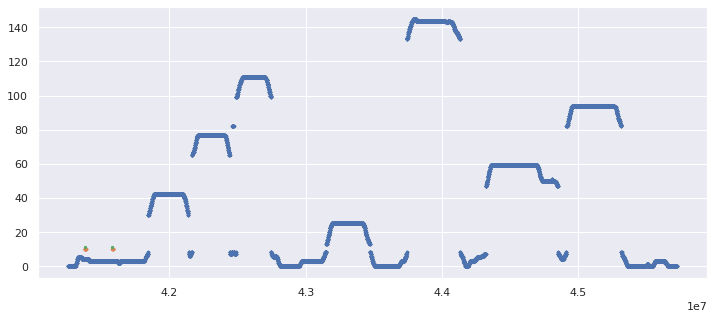

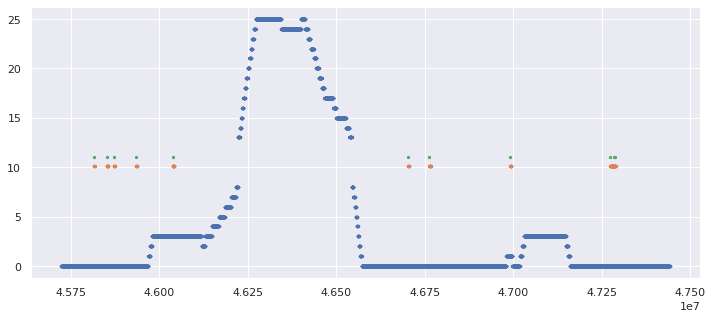

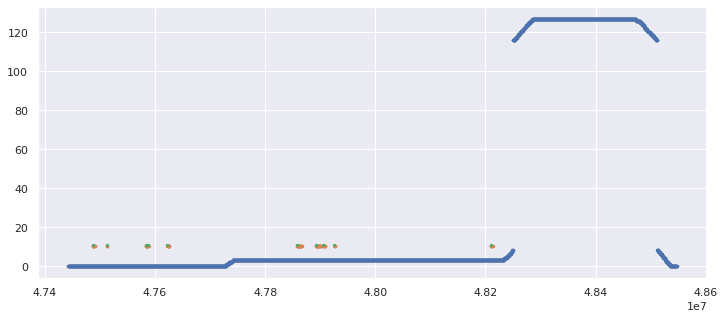

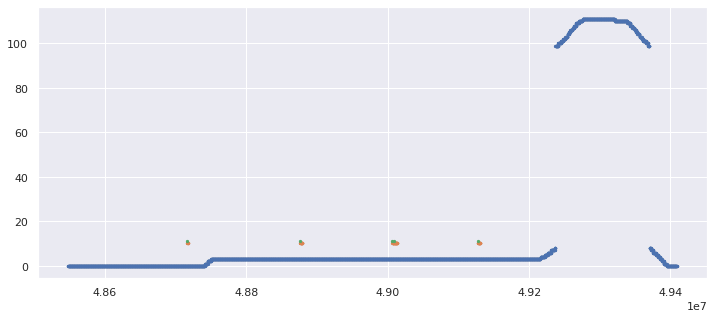

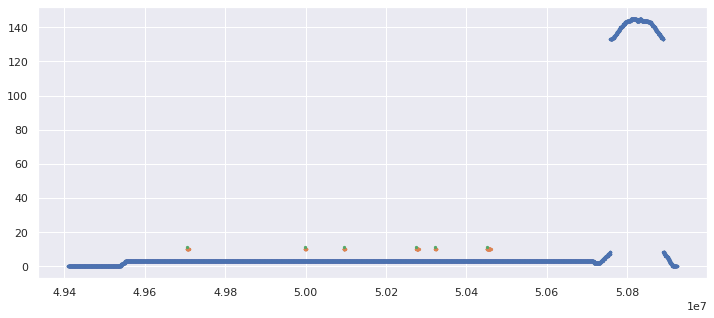

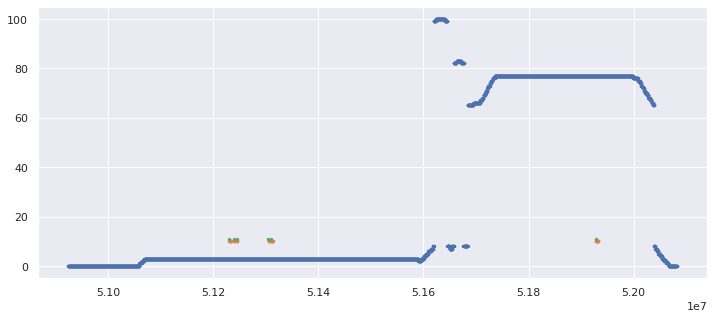

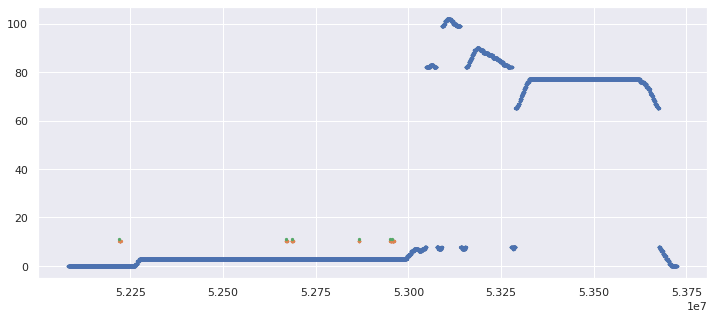

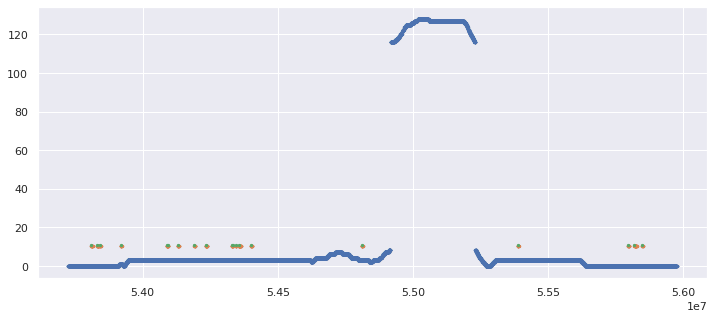

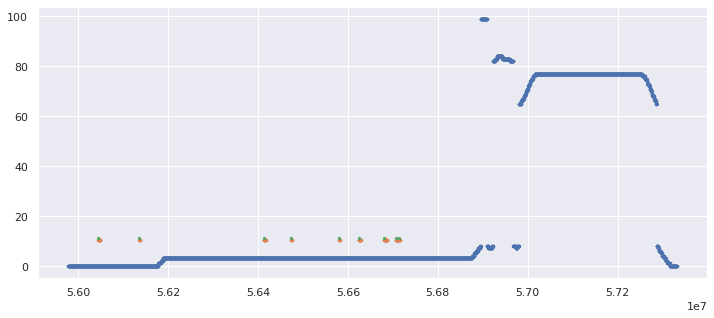

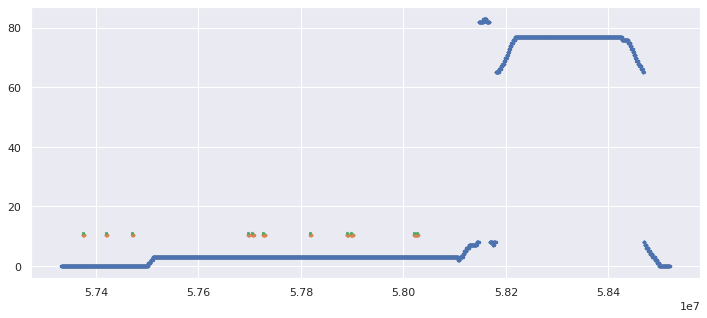

In [123]:
#plotting to check ripple detection offline and realtime

for i in np.arange(0,10):
    trial_start = trials_timestamp['start_ts'][i:i+1].values[0]
    trial_end = trials_timestamp['end_ts'][i:i+1].values[0]
    trial_post = merged_off_post_pos[(merged_off_post_pos['timestamp'].values > trial_start) & (merged_off_post_pos['timestamp'].values < trial_end)]
    trial_post_rips = trial_post[trial_post['ripple_grp']>0]
    all_rips = rips.reset_index()
    all_rips_plot = all_rips[(all_rips['timestamp'].values > trial_start) & (all_rips['timestamp'].values < trial_end)]
    plt.figure(figsize=(12,5))
    plt.scatter(trial_post['timestamp'].values,trial_post['linpos_flat'].values,s=5)
    plt.scatter(trial_post_rips['timestamp'].values,(trial_post_rips['ripple_grp'].values/1000)+10,s=5)
    plt.scatter(all_rips_plot['timestamp'].values,np.repeat(11,len(all_rips_plot)),s=5)


In [122]:
np.repeat(11,len(all_rips_plot))

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

In [124]:
#calculate max for offline posteriors
post_to_merge = posteriors2.copy()

#calculate posterior max
post_to_merge1 = post_to_merge.drop(['num_spikes','dec_bin','ripple_grp'], axis=1)
post_to_merge1.fillna(0,inplace=True)
post_to_merge1['posterior_max'] = post_to_merge1.idxmax(axis=1)
post_to_merge1['posterior_max'] = post_to_merge1['posterior_max'].str.replace('x','')
post_to_merge1['posterior_max'] = post_to_merge1['posterior_max'].astype(int)

#post_to_merge.reset_index(level=['timestamp'],inplace=True)
post_to_merge1.reset_index(inplace=True)
post_to_merge1['timestamp1']=post_to_merge1['timestamp']

#calculate posterior max

#post_to_merge.set_index('timestamp', append=True, inplace=True)
#post_to_merge.set_index('dat','epoch','timestamp', 'time',append=True, inplace=True)
#post_to_merge1 = post_to_merge.reorder_levels(['day', 'epoch', 'timestamp', 'time'])
post_to_merge1

pos_vel = binned_linear_pos.copy()
pos_vel1 = pos_vel.reset_index()
pos_vel1['timestamp1'] = pos_vel1['timestamp']
pos_vel2 = pos_vel1.drop(['day','epoch','time','timestamp'], axis=1)

posterior_with_pos_vel = pd.merge_asof(post_to_merge1,pos_vel2,on='timestamp1',direction='nearest')
posterior_with_pos_vel['error_cm'] = abs(posterior_with_pos_vel['posterior_max']-posterior_with_pos_vel['linpos_flat'])*5
posterior_with_pos_vel

post_error_plot_off = posterior_with_pos_vel.copy()
#post_error_plot_off = post_error_plot[100:821700]
post_error_plot_off = post_error_plot_off[post_error_plot_off['linvel_flat']>4]
post_error_plot_off.shape

(194133, 155)

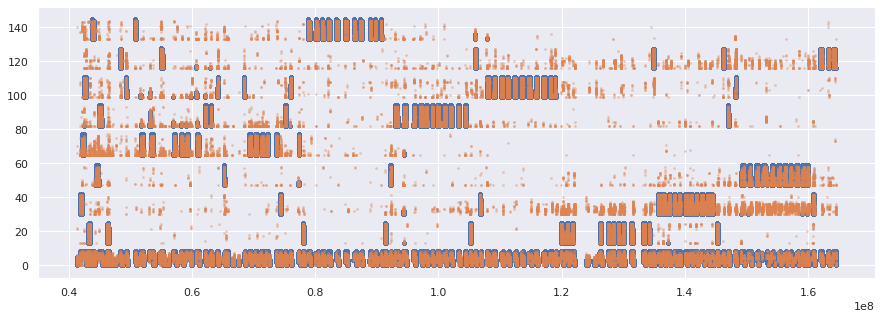

In [125]:
#offline position and decoded position
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['linpos_flat'].values,s=10)
plt.scatter(post_error_plot_off['timestamp'].values,post_error_plot_off['posterior_max'].values,s=3,alpha=0.3)


In [142]:
# for real-time posterior
#post_error1 = decoder_data.copy()
post_error1 = likelihood_data.copy()

#post_error1.drop(columns=['rec_ind','wall_time','bin_timestamp','velocity','real_pos','spike_count','ripple',
#                          'ripple_number','ripple_length','shortcut_message','box','arm1','arm2','arm3','arm4','arm5',
#                          'arm6','arm7','arm8','raw_x','raw_y','smooth_x','smooth_y'],inplace=True)

post_error1.drop(columns=['rec_ind','wall_time','bin_timestamp','real_pos','spike_count'],inplace=True)

post_error1.fillna(0,inplace=True)
post_error1['max_position'] = post_error1.idxmax(axis=1)
post_error1['max_position'] = post_error1['max_position'].str.replace('x','')
post_error1['max_position'] = post_error1['max_position'].astype(int)

#now need to add back columns 'timestamp','real_pos_time','real_pos'
# try adding back spike_count too
post_error1['timestamp'] = likelihood_data['bin_timestamp']
#post_error1['real_vel'] = decoder_data['velocity']
post_error1['real_pos'] = likelihood_data['real_pos']
post_error1['spike_count'] = likelihood_data['spike_count']
#this is the error column in centimeters
post_error1['error_cm'] = abs(post_error1['max_position']-likelihood_data['real_pos'])*5

post_error1.shape
#post_error_plot_realtime = post_error1[post_error1['real_vel']>8]
#post_error_plot_realtime.shape

(563021, 142)

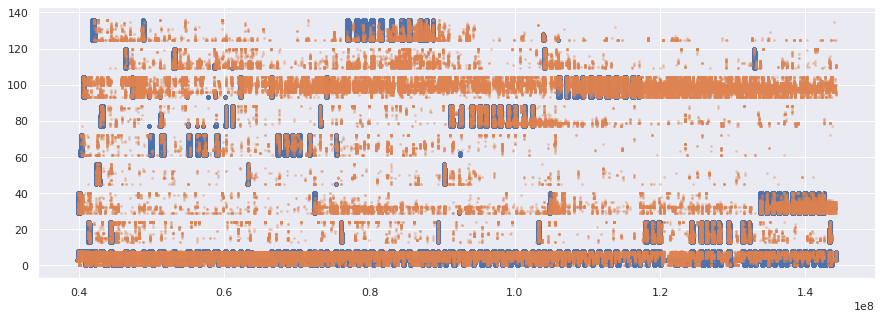

In [136]:
# remy day 20 epoch 2 realtime - greenflash
# 150 uV, 15 tets, no timer
plt.figure(figsize=(15,5))

plt.scatter(post_error_plot_realtime['timestamp'].values,post_error_plot_realtime['real_pos'].values,s=10)
plt.scatter(post_error_plot_realtime['timestamp'].values,post_error_plot_realtime['max_position'].values,s=3,alpha=0.3)


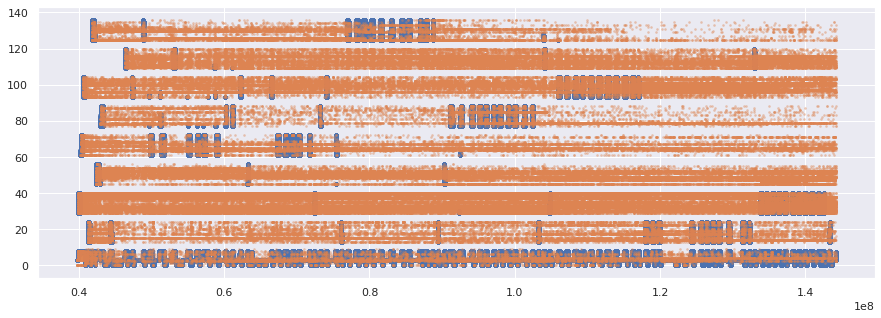

In [143]:
# remy day 20 epoch 2 realtime - likelihoods
# 150 uV, 15 tets, no timer
plt.figure(figsize=(15,5))

plt.scatter(post_error1['timestamp'].values,post_error1['real_pos'].values,s=10)
plt.scatter(post_error1['timestamp'].values,post_error1['max_position'].values,s=3,alpha=0.3)


In [141]:
likelihood_data

,rec_ind,bin_timestamp,wall_time,real_pos,spike_count,x000,x001,x002,x003,x004,...,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136
0,1,39691950,1.579222e+09,3.0,2,0.007299,0.007299,0.007299,0.001460,0.007299,...,0.007299,0.007299,0.007299,0.007299,0.007299,0.007299,0.007299,7.299247e-03,0.007299,7.299247e-03
1,3,39692100,1.579222e+09,3.0,2,0.000003,0.000003,0.000003,0.007302,0.000003,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,2.600907e-06,0.000003,2.600907e-06
2,5,39692250,1.579222e+09,3.0,2,0.000342,0.000342,0.000342,0.007302,0.000342,...,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,0.000342,3.424907e-04,0.000342,3.424907e-04
3,7,39692400,1.579222e+09,3.0,1,0.007299,0.007299,0.007299,0.001460,0.007299,...,0.007299,0.007299,0.007299,0.007299,0.007299,0.007299,0.007299,7.299248e-03,0.007299,7.299248e-03
4,9,39692550,1.579222e+09,3.0,1,0.007299,0.007299,0.007299,0.001217,0.007299,...,0.007299,0.007299,0.007299,0.007299,0.007299,0.007299,0.007299,7.299248e-03,0.007299,7.299248e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563016,1195007,144173100,1.579225e+09,7.0,1,0.000063,0.001562,0.001359,0.000422,0.000817,...,0.000119,0.000029,0.000044,0.000093,0.000026,0.000008,0.000011,1.925558e-07,0.000002,9.941656e-08
563017,1195009,144173250,1.579225e+09,7.0,3,0.000382,0.003028,0.002590,0.001352,0.002632,...,0.000268,0.000054,0.000114,0.000055,0.000037,0.000049,0.000263,5.718490e-06,0.000025,6.803553e-06
563018,1195011,144173550,1.579225e+09,7.0,1,0.003690,0.005260,0.005705,0.005159,0.006054,...,0.004288,0.004487,0.003523,0.002431,0.004270,0.004302,0.003888,4.131516e-03,0.004276,5.695237e-03
563019,1195013,144173700,1.579225e+09,7.0,2,0.000030,0.000249,0.000760,0.000080,0.001951,...,0.000122,0.000243,0.001008,0.000111,0.000012,0.000002,0.000093,2.768994e-05,0.000124,9.803987e-05
